In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits

In [3]:
# Let's first look at the data
stokes = fits.open("/home/milic/data/Hinode_network/hinode_network_c.fits")[0].data

In [4]:
stokes.shape
stokes /= np.mean(stokes[:,:,0,:10])

In [5]:
# Let's also assign wavelengths:
ll = np.linspace(0,111,112)
ll = 6302.08 + (ll-56.5)*0.0215

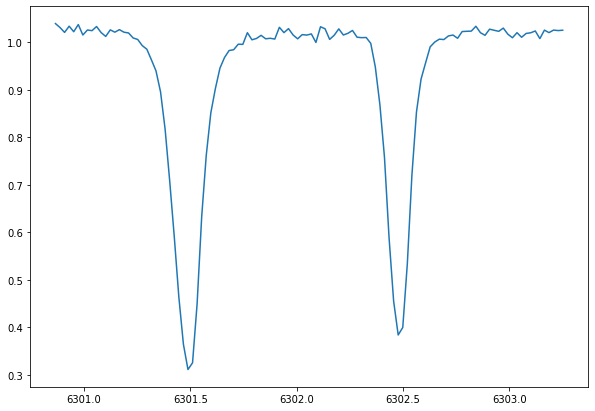

In [6]:
# Plot one spectrum:
plt.figure(figsize=[10,7])
plt.plot(ll,stokes[100,100,0,:])

In [7]:
# Now we need to fit this. Let's first code the model. 
from scipy.special import wofz
def V(x, alpha, gamma):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.

    """
    sigma = alpha / np.sqrt(2 * np.log(2))

    return np.real(wofz((x + 1j*gamma)/sigma/np.sqrt(2))) / sigma /np.sqrt(2*np.pi)

def voigt(center,doppler,damp,ll):
    xx = (ll - center)/doppler
    return V(xx,1.0,damp)
    

In [9]:
# check if it works!
#plt.figure(figsize=[10,7])
#plt.plot(ll,voigt(6301.5,0.05,1E-2,ll))

In [10]:
# Now let's define ou model and relevant probabilities
def me_scalar(p,ll):
    # for clarity
    a0,a1,eta,shift,width,damping = p
    # let's assume the width is in km/s units
    width *= np.mean(ll)/2.997E5
    # le's assume the shift is also in km/s 
    center = 6301.49 * (1.+shift/2.997E5)
    profile = voigt(center,width,damping,ll)
    r_lambda = 1. + profile * eta
    return a0 + a1/r_lambda

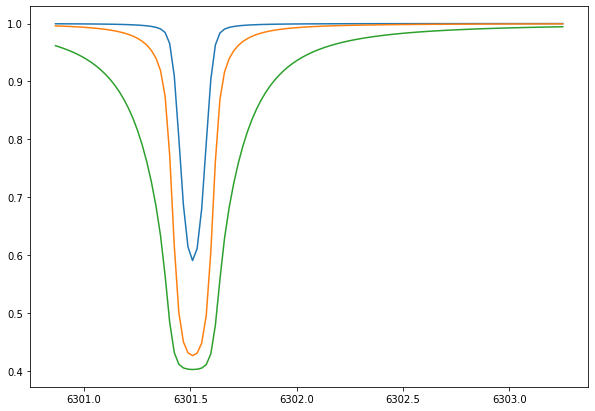

In [11]:
# Let's see if it works
plt.figure(figsize=[10,7])
plt.plot(ll,me_scalar([0.4,0.6,5.,1.0,2.0,1E-1],ll))
plt.plot(ll,me_scalar([0.4,0.6,50.,1.0,2.0,1E-1],ll))
plt.plot(ll,me_scalar([0.4,0.6,500.,1.0,2.0,1E-1],ll))

In [13]:
# Now the relevant probabilities
def ln_prior(params):
    # Both slope and offset positive
    a0,a1,eta,shift,width,damping = params
    if (a0 < 0):
        return -np.infty
    if (a1 < 0):
        return -np.infty
    if (eta < 0 or eta > 200.):
        return - np.infty
    if (shift < -20. or shift > 20.):
        return - np.infty
    if (shift < -10. or shift > 10.):
        return - 22.
    if (width < 0.1 or width > 10.0):
        return - np.infty
    if (damping < 1E-4 or damping > 1.0):
        return - np.infty
    return 0.

def ln_like(params, x, y, error):
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return -0.5 * chi2 # - 0.5*np.log(2*np.pi) - np.log(error)) # I am making it depend on errors in purpose

def ln_post(params, x, y, error):
    
    lnprior_val = ln_prior(params)
    
    if ~np.isfinite(lnprior_val):
        return lnprior_val
    else:           
        lnlike_val = ln_like(params, x, y, error)
        return lnprior_val + lnlike_val

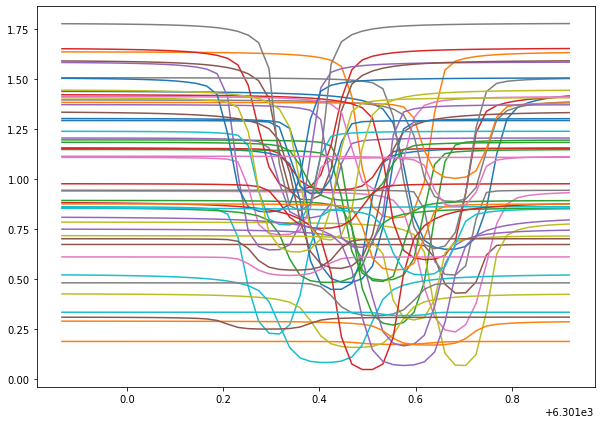

In [14]:
import emcee
ndim = 6
nwalkers = 50 # this is number of random points
i = 150
j = 150

x_data = ll[:50]
y_data = stokes[i,j,0,:50]
errors = np.zeros(50)
errors[:] = y_data[0]*1E-2


starting_params = np.zeros([nwalkers,ndim])
starting_params[:,0] = np.random.uniform(0.,1.,nwalkers)
starting_params[:,1] = np.random.uniform(0.,1.,nwalkers)
starting_params[:,2] = np.random.uniform(10.,100.,nwalkers)
starting_params[:,3] = np.random.uniform(-10.,10.,nwalkers)
starting_params[:,4] = np.random.uniform(1.0,2.0,nwalkers)
starting_params[:,5] = np.random.uniform(1E-2,1E-1,nwalkers)

plt.figure(figsize=[10,7])
for i in range (0,nwalkers):
    plt.plot(x_data,me_scalar(starting_params[i,:],x_data))

In [15]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_post, args=[x_data,y_data,errors])

num_steps = 2000
test1,test2,test3 = sampler.run_mcmc(starting_params, num_steps)

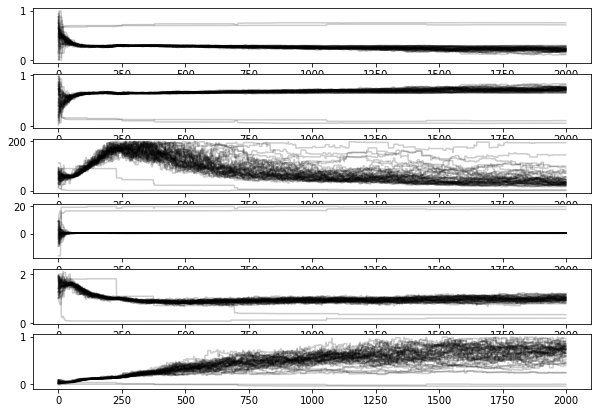

In [16]:
plt.figure(figsize=[10,7])
plt.subplot(611)
plt.plot(sampler.chain[:, :, 0].T, '-k', alpha=0.2)
plt.subplot(612)
plt.plot(sampler.chain[:, :, 1].T, '-k', alpha=0.2)
plt.subplot(613)
plt.plot(sampler.chain[:, :, 2].T, '-k', alpha=0.2)
plt.subplot(614)
plt.plot(sampler.chain[:, :, 3].T, '-k', alpha=0.2)
plt.subplot(615)
plt.plot(sampler.chain[:, :, 4].T, '-k', alpha=0.2)
plt.subplot(616)
plt.plot(sampler.chain[:, :, 5].T, '-k', alpha=0.2)

In [17]:
best = np.median(sampler.flatchain,axis=0)
print (best)

[ 0.2704425   0.67289744 65.83394845  0.375519    0.94062812  0.4633111 ]


-23.481615784540296


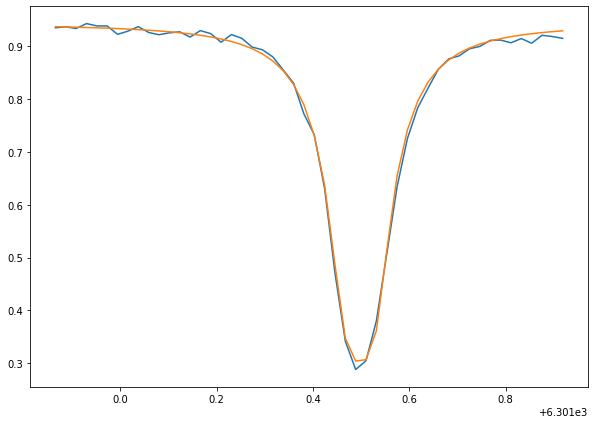

In [18]:
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)
plt.plot(x_data,me_scalar(best,x_data))
print (ln_like(best,x_data,y_data,errors))

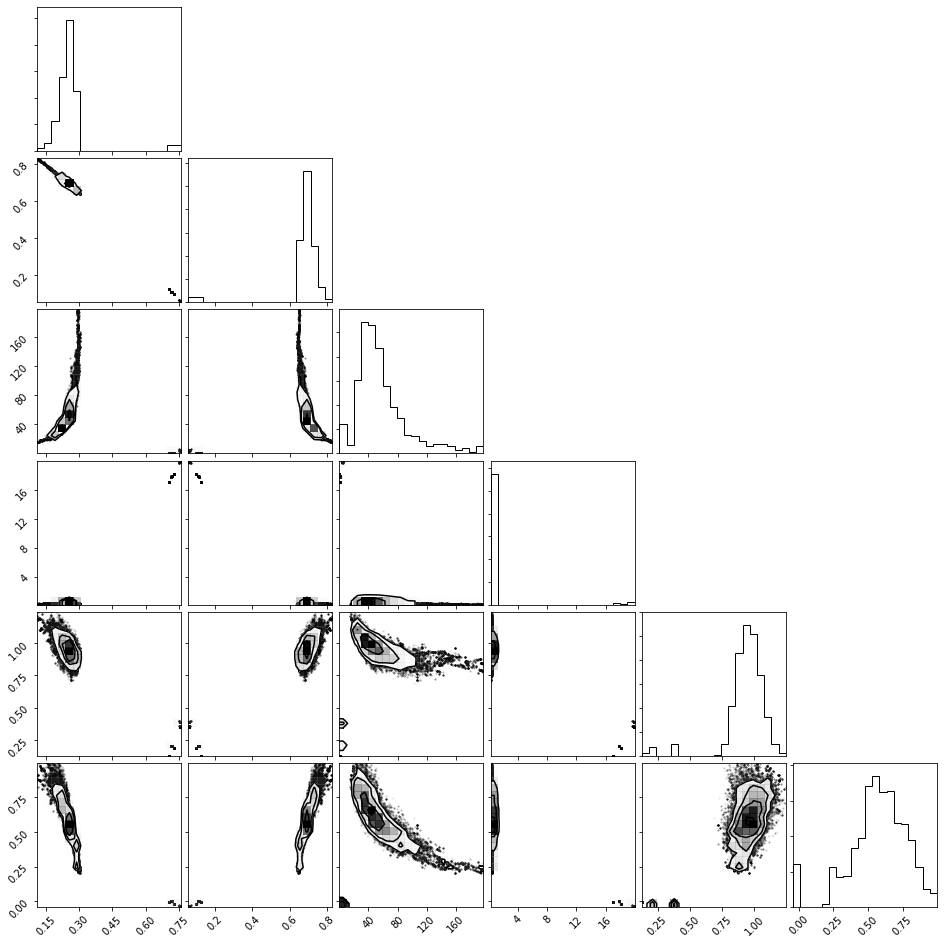

In [19]:
#import corner
#figure = corner.corner(sampler.flatchain[40000:])

In [25]:
#let's try now scipy.optimize.minimize

def chi2(params, x,y,error):
    
    y_model = me_scalar(params,x)
    
    chi2 = np.sum(((y_model - y) / error)**2)
    
    return chi2

In [26]:
from scipy.optimize import minimize

[ 1.03221151 -0.23977207  2.7335641  16.2720266   4.25571432  0.0673255 ]
[ 0.23522073  0.70762812 39.38314225  0.37083191  1.00417503  0.66746146]
[-5.05228337  5.97772548  0.33807107  0.4073417   2.89292716  0.35309981]
[ 0.16332315  0.77831564 21.21751272  0.37053831  1.12616668  0.85159414]
[ 0.27682058  0.6673374  84.44633513  0.38001271  0.91392723  0.41347716]
[ 0.15686175  0.63979978 -0.35934533 16.35984655  5.69217889 -0.05485729]
[ 0.13846263  0.80297245 18.37375447  0.37080791  1.15657313  0.89675603]
[ 0.96822436 -0.17316446  6.31392585 15.75542831  3.77232613  0.05069115]
[2.21910339e-02 7.99583532e-01 3.52336431e+01 9.75274033e+00
 1.05386089e-06 7.87420193e-02]
[ 2.16538350e-01  6.05235502e-01  1.23980969e+01 -9.88334000e+00
  5.96978468e-07  4.66884127e-02]
[-0.45643483  1.36964202  1.7137774   0.38634712  3.00589525  0.04876012]
[  0.2477818    0.70126173 176.96959178   0.35990521   0.37614009
   1.30791994]
[-2.67329841  3.60423307  0.78318247  0.37599961  2.33546719 

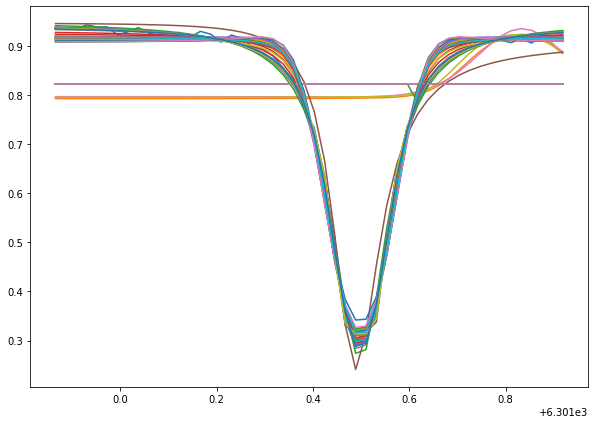

In [34]:
plt.figure(figsize=[10,7])
plt.plot(x_data,y_data)

for i in range(0,50):
    
    result = minimize(chi2,starting_params[i],args=(x_data,y_data,errors),method='Nelder-Mead')
    print (result.x)
    plt.plot(x_data,me_scalar(result.x,x_data))
    
